<a href="https://colab.research.google.com/github/seungjae6874/Face-recognition/blob/master/siamese_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# 코드로 형식 지정됨
Imports
모든 import 해야 할 것들을 정의해 줍니다.

In [0]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

Helper functions
필요한 함수들을 설정해줍니다.

In [0]:
def imshow(img,text = None, should_save = False):
  npimg = img.numpy()
  plt.axis("off")
  if text:
    plt.text(75,8,text, style='italic',fontweight='bold',
             bbox={'facecolor':'white','alpha':0.8,'pad':10})
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Configuration Class
간단한 클래스들을 통해 data사진이 있는 경로를 선언해주고 에폭과 배치사이즈를 설정해줍니다.

In [0]:
class Config():
  training_dir = "/content/drive/My Drive/siamese/data/faces/training"
  testing_dir = "/content/drive/My Drive/siamese/data/faces/testing"
  train_batch_size = 64
  train_number_epochs = 100

Custom Dataset Class
데이터셋은 한 쌍의 이미지들로써 생성됩니다.
0의 값은 정답의 이미지를 갖는 쌍
1의 값은 거짓의 사진 즉, 일치하지 않는 사진인 쌍을 의미합니다.

In [0]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Using Image Folder Dataset

In [0]:
folder_dataset= dset.ImageFolder(root = Config.training_dir)

In [0]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                       transforms.ToTensor()]),should_invert=False)

Visualising some of the data
이제 데이터를 로드한 후에 훈련시에는 shuffle을 하고 한번 돌려보자
한쌍의 사진에 대해 1이면 두 사진은 맞지 않고 0이면 같은 인물임을 판단해낸다.

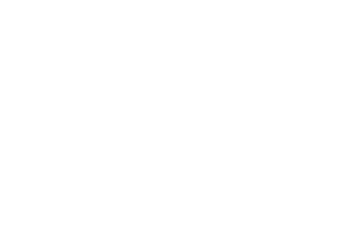

[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [43]:
vis_dataloader = DataLoader(siamese_dataset,shuffle=True,num_workers=8,batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenate = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenate))
plt.show()
print(example_batch[2].numpy())